In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

## Importing data

In [4]:
# Dataset folders 
dataset_dir = '/kaggle/input/an2dl-challenge-1-nt/data_splitted_no_test'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')

In [5]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the 
# ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator, and for the trainign with Data Augmentation
train_data_gen = ImageDataGenerator(rotation_range=15, 
                                    height_shift_range=0.2, 
                                    width_shift_range=0.2, 
                                    zoom_range=0.2, 
                                    horizontal_flip=True, 
                                    shear_range=0.2, 
                                    fill_mode='reflect',
                                    rescale=1/255.) # rescale value is multiplied to the image ############################################
valid_data_gen = ImageDataGenerator(rescale=1/255.)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=training_dir,
                                                       target_size=(96,96),
                                                       color_mode='rgb',
                                                       classes=None, # can be set to labels
                                                       class_mode='categorical',
                                                       batch_size=8,
                                                       shuffle=True,
                                                       seed=seed)

valid_gen = valid_data_gen.flow_from_directory(directory=validation_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, # can be set to labels
                                               class_mode='categorical',
                                               batch_size=8,
                                               shuffle=False,
                                               seed=seed)

Found 3648 images belonging to 8 classes.
Found 648 images belonging to 8 classes.


## Model

In [6]:
import os
os.listdir("/kaggle/input/inceptionv3/IN_v1.2.1")

['variables', 'saved_model.pb', 'keras_metadata.pb']

In [7]:
# Re-load the model after transfer learning
IN = tfk.models.load_model('/kaggle/input/inceptionv3/IN_v1.2.1')
IN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier1 (Dense)          (None, 512)               1049088   
_________________________________________________________________
activation_94 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 512)               2048  

In [8]:
'''# to create a folder
import os
directory = "Inception"
parent_dir = "/kaggle/working"
path = os.path.join(parent_dir, directory)
os.mkdir(path)'''

'# to create a folder\nimport os\ndirectory = "Inception"\nparent_dir = "/kaggle/working"\npath = os.path.join(parent_dir, directory)\nos.mkdir(path)'

In [9]:
!cd /kaggle/working/Inception

/bin/bash: line 0: cd: /kaggle/working/Inception: No such file or directory


In [10]:
# Set all VGG layers to True
IN.get_layer('inception_v3').trainable = True

In [11]:
'''for i, layer in enumerate(IN.get_layer('inception_v3').layers):
   print(i, layer.name, layer.trainable)'''

"for i, layer in enumerate(IN.get_layer('inception_v3').layers):\n   print(i, layer.name, layer.trainable)"

In [12]:
# Freeze first N layers (because the first layers has learned the edges, and they usually are still good)
# we can set this aspect as an hyperparam
N = 132
for i, layer in enumerate(IN.get_layer('inception_v3').layers[:N]):
  layer.trainable=False
IN.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 96, 96, 3)]       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 1, 1, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
Classifier1 (Dense)          (None, 512)               1049088   
_________________________________________________________________
activation_94 (Activation)   (None, 512)               0         
_________________________________________________________________
batch_normalization_94 (Batc (None, 512)               2048  

## Training

In [13]:
# Compile the model
IN.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.RMSprop(learning_rate=0.0001), metrics='accuracy')

In [14]:
# Fine-tune the model
IN_history = IN.fit(
    x = train_gen,
    batch_size = 256,
    epochs = 200,
    validation_data = valid_gen,
    #callbacks = callbacks,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', 
                                             mode='max', 
                                             patience=40, 
                                             restore_best_weights=True)],
).history

Epoch 1/200
456/456 [==============================] - 49s 73ms/step - loss: 1.9001 - accuracy: 0.3103 - val_loss: 1.6620 - val_accuracy: 0.4136
Epoch 2/200
456/456 [==============================] - 24s 53ms/step - loss: 1.6394 - accuracy: 0.4052 - val_loss: 1.7555 - val_accuracy: 0.4691
Epoch 3/200
456/456 [==============================] - 25s 56ms/step - loss: 1.5570 - accuracy: 0.4465 - val_loss: 1.7686 - val_accuracy: 0.5648
Epoch 4/200
456/456 [==============================] - 24s 52ms/step - loss: 1.4748 - accuracy: 0.4729 - val_loss: 1.2754 - val_accuracy: 0.6265
Epoch 5/200
456/456 [==============================] - 24s 53ms/step - loss: 1.4003 - accuracy: 0.5047 - val_loss: 1.2029 - val_accuracy: 0.6096
Epoch 6/200
456/456 [==============================] - 24s 53ms/step - loss: 1.3403 - accuracy: 0.5266 - val_loss: 1.5256 - val_accuracy: 0.6682
Epoch 7/200
456/456 [==============================] - 25s 55ms/step - loss: 1.3212 - accuracy: 0.5403 - val_loss: 1.2156 - val_ac

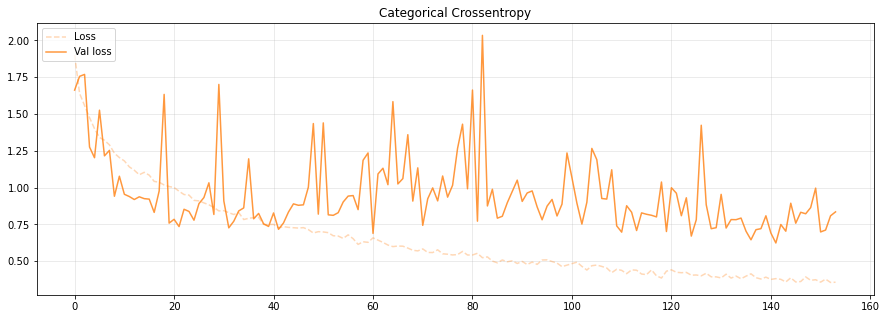

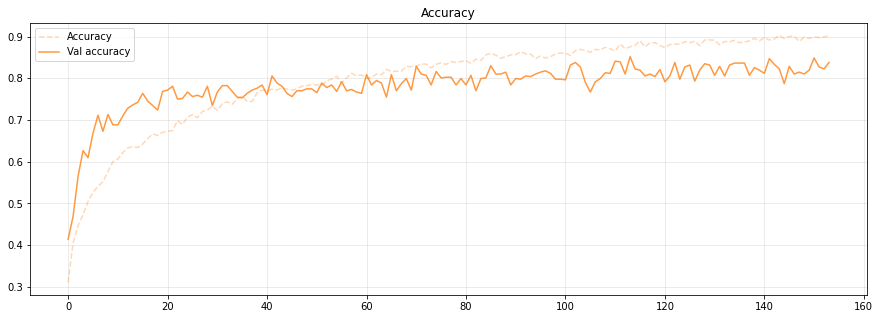

In [15]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(IN_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(IN_history['val_loss'], label='Val loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)
plt.savefig('IN_v1.2.2_loss.png')

plt.figure(figsize=(15,5))
plt.plot(IN_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(IN_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('IN_v1.2.2_acc.png')

plt.show()

In [16]:
# Save the best model
IN.save('IN_v1.2.2')

In [17]:
# Evaluate on val
val_metrics = IN.evaluate(valid_gen, return_dict=True)

print()
print("Val metrics")
print(val_metrics)

81/81 [==============================] - 2s 22ms/step - loss: 0.7083 - accuracy: 0.8519

Val metrics
{'loss': 0.7083420753479004, 'accuracy': 0.8518518805503845}


In [18]:
import shutil
shutil.make_archive("IN_v1.2.2", 'zip', "/kaggle/working/IN_v1.2.2")

'/kaggle/working/IN_v1.2.2.zip'

In [19]:
# To delete a folder
import shutil
shutil.rmtree("/kaggle/working/IN_v1.2.2")